In [1]:
# import libraries

import numpy as np
from astropy.io import fits
from photutils import datasets
import matplotlib.pyplot as plt
from photutils import find_peaks
from photutils import DAOStarFinder
from photutils import IRAFStarFinder
from photutils import CircularAperture
from astropy.stats import sigma_clipped_stats
from astropy.visualization import simple_norm
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [2]:
# The following code shows how we can open a FITS file and print out its header information:

hdulist = fits.open('./dataset2/g_prime/CCDC-LIGHT-20210110233126.fits')
hdulist.info()

Filename: ./dataset2/g_prime/CCDC-LIGHT-20210110233126.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (3352, 2532)   int16 (rescales to uint16)   


In [3]:
data = hdulist[0].data[0:400,0:400]

In [4]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
print((mean, median, std))

(3092.833431571311, 3092.0, 87.29413755065907)


In [5]:
#Now we will subtract the background and use an instance of DAOStarFinder 
#to find the stars in the image that have FWHMs of around 3 pixels and have
#peaks approximately 5-sigma above the background. Running this class 
#on the data yields an astropy Table containing the results of the star finder:

# DAOStarFinder is a class that provides an implementation of the DAOFIND algorithm 
# (Stetson 1987, PASP 99, 191). It searches images for local density maxima that have a peak 
# amplitude greater than a specified threshold (the threshold is applied to a convolved image)
# and have a size and shape similar to a defined 2D Gaussian kernel. DAOStarFinder also 
# provides an estimate of the objects’ roundness and sharpness, whose lower and upper bounds
# can be specified.

daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
sources = daofind(data - median)  
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)  

 id xcentroid ycentroid  sharpness  ... sky  peak    flux       mag     
--- --------- ---------- ---------- ... --- ----- --------- ------------
  1 213.37525 0.13151205 0.95854535 ...   0  7357   10.9997   -2.6034521
  2 371.18383 0.72656044 0.58500464 ...   0  2922 6.2167858   -1.9839148
  3 249.28006  3.1249671 0.87077716 ...   0  6491 10.857882   -2.5893628
  4 42.262154  4.4533379 0.43228386 ...   0  1382 3.2400653   -1.2763844
  5 71.163703  5.1647657 0.72814692 ...   0   872 1.4477136  -0.40170667
  6  147.5156  5.9748368 0.77034646 ...   0  1221 2.0461508   -0.7773441
  7 182.76189  6.4399992 0.71833829 ...   0  1256 2.3150841  -0.91141694
  8 175.59872  9.3613297  0.6972655 ...   0   822 1.5893945  -0.50307929
  9 379.68474  8.9566205 0.90581284 ...   0  8673 14.389283   -2.8950979
 10 392.50033  10.082237 0.93291362 ...   0 15096 24.374966   -3.4673601
...       ...        ...        ... ... ...   ...       ...          ...
164  121.6741  378.42491 0.81077609 ...   0  9216 1

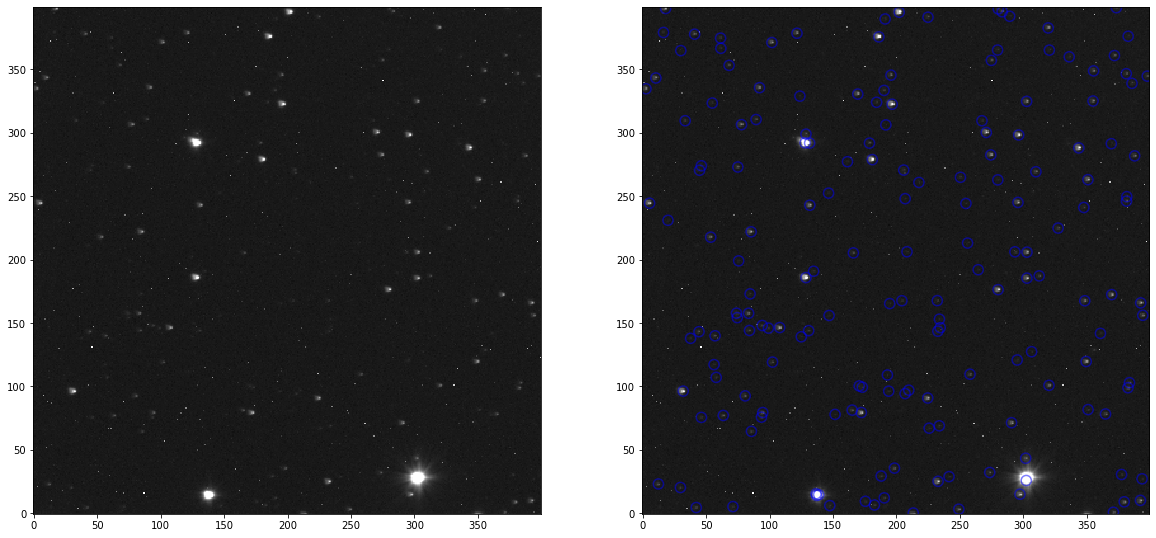

In [6]:
#visualizing
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(data, cmap='Greys_r', origin='lower', norm=norm, interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
axs[1].imshow(data, norm=norm, origin='lower', cmap='Greys_r', interpolation='nearest')

In [7]:
#Photutils also includes a find_peaks() function to find local peaks in an image
# that are above a specified threshold value. Peaks are the local maxima above a
# specified threshold that are separated by a specified minimum number of pixels.
#As a simple example, let’s find the local peaks in an image that are 5 sigma above
# the background and a separated by at least 5 pixels:

mean, median, std = sigma_clipped_stats(data, sigma=3.0)
threshold = median + (5. * std)
tbl = find_peaks(data, threshold, box_size=11)
tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(tbl[:10])  # print only the first 10 peaks

x_peak y_peak peak_value
------ ------ ----------
   214      0      10449
   325      0       3647
   349      0      12600
   101      1       3702
   288      1       3612
   371      1       6014
   394      1       8053
   250      3       9583
    35      4      20537
    42      4       4694


(0.0, 399.0)

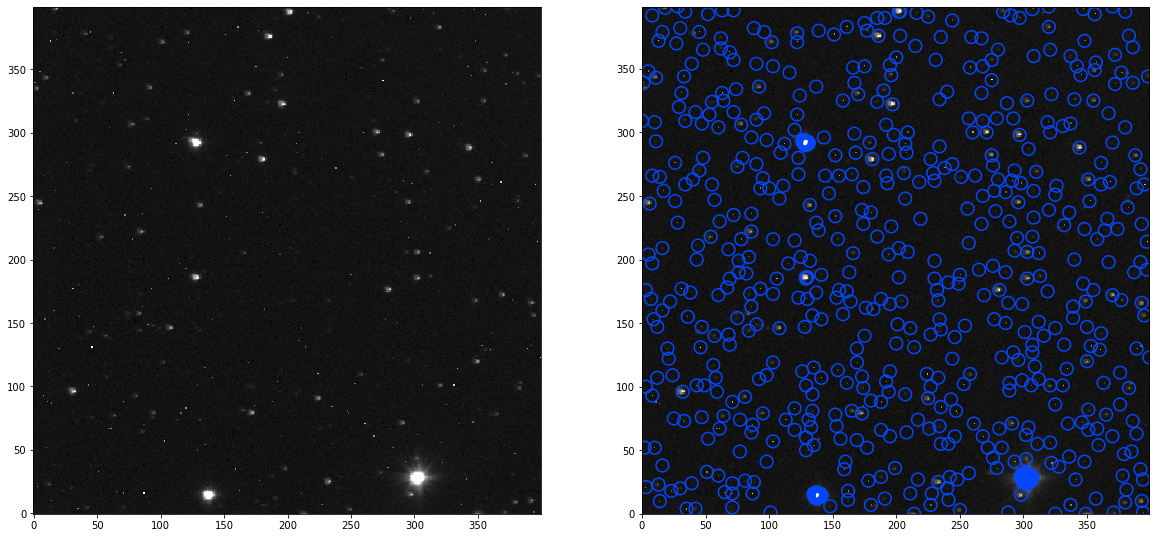

In [8]:
#And let’s plot the location of the detected peaks in the image:
positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
apertures = CircularAperture(positions, r=5.)
norm = simple_norm(data, 'sqrt', percent=99.9)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(data, cmap='Greys_r', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='#0547f9', lw=1.5)
axs[1].imshow(data, norm=norm, origin='lower', cmap='Greys_r', interpolation='nearest')
plt.xlim(0, data.shape[1]-1)
plt.ylim(0, data.shape[0]-1)